# Project 11: Price Prediction - Rusty Bargain Car 

🎯  **Project Goal**

Predict used car prices based on historical data to help users estimate the market value of their vehicles quickly and accurately. 

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

# Import the Standard, Model & Metrics Libraries

In [10]:
# standard libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from math import sqrt
import time
import joblib

# modeling & metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


In [16]:
print(os.getcwd())

C:\Users\Eva Brown\github_projects_datasets_02


## Data preparation

*Goal*: Clean and explore the dataset to get it modeling ready. 

### **Load the Dataset (and display first few rows)**

In [26]:
cars_data = pd.read_csv('datasets/car_data.csv')

In [28]:
cars_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [30]:
cars_data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Mileage', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [32]:
# Version before changes.
cars_data_backup = cars_data.copy()

In [34]:
cars_data.columns = cars_data.columns.str.lower()

In [36]:
cars_data.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'mileage', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

### **Check for Missing Values**

In [39]:
cars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   mileage            354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [41]:
# calculate missing values 
cars_data.isna().sum()

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
mileage                  0
registrationmonth        0
fueltype             32895
brand                    0
notrepaired          71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

In [43]:
# calculate total and percentage of missing values 
missing_total = cars_data.isna().sum()
missing_percentage = (missing_total / len(cars_data)) * 100

In [45]:
# missing values dataframe
missing_df = pd.DataFrame({
    'missing_values': missing_total, 
    "percent_missing": missing_percentage.round(2)
})

In [47]:
# add "Notes" (Categorical/Numerical)
# use dtypes to assign a 'note'
missing_df['notes'] = cars_data.dtypes.apply(
lambda  dtype: 'categorical' if dtype == 'object' else 'numerical')

In [49]:
# filter to show only columns with missing values 
missing_df  = missing_df[missing_df['missing_values'] > 0].sort_values(by='percent_missing', ascending=False)

In [51]:
# display the missing_df table
display(missing_df)

,missing_values,percent_missing,notes
notrepaired,71154,20.08,categorical
vehicletype,37490,10.58,categorical
fueltype,32895,9.28,categorical
gearbox,19833,5.60,categorical
model,19705,5.56,categorical


### **Handle Missing Data & Analyze data types (catergorical, numerical)**

In [54]:
# impute missing values in categorical columns with 'unknown', for now
cols_to_impute = ['vehicletype', 'gearbox', 'model', 'fueltype', 'notrepaired']

cars_data[cols_to_impute] = cars_data[cols_to_impute].fillna('unknown')

In [56]:
# Sanity Check on columns to impute
print("Columns exist:", all(col in cars_data.columns for col in cols_to_impute))

Columns exist: True


In [58]:
# check their data types
print('\n Column Data Types:')
print(cars_data[cols_to_impute].dtypes)


 Column Data Types:
vehicletype    object
gearbox        object
model          object
fueltype       object
notrepaired    object
dtype: object


In [60]:
# check missing values AFTER imputation
print('\n Missing Values Remaining:')
print(cars_data[cols_to_impute].isna().sum())


 Missing Values Remaining:
vehicletype    0
gearbox        0
model          0
fueltype       0
notrepaired    0
dtype: int64


In [62]:
#  Preview sample values to confirm 'unknown' was filled
print("\n Sample Values Check:")
for col in cols_to_impute:
    print(f"\n{col} sample values:")
    print(cars_data[col].value_counts(dropna=False).head(3))


 Sample Values Check:

vehicletype sample values:
vehicletype
sedan    91457
small    79831
wagon    65166
Name: count, dtype: int64

gearbox sample values:
gearbox
manual     268251
auto        66285
unknown     19833
Name: count, dtype: int64

model sample values:
model
golf     29232
other    24421
3er      19761
Name: count, dtype: int64

fueltype sample values:
fueltype
petrol      216352
gasoline     98720
unknown      32895
Name: count, dtype: int64

notrepaired sample values:
notrepaired
no         247161
unknown     71154
yes         36054
Name: count, dtype: int64


In [64]:
# sanity check post-imputation & Pre-encoding
cars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        354369 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            354369 non-null  object
 5   power              354369 non-null  int64 
 6   model              354369 non-null  object
 7   mileage            354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           354369 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        354369 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [66]:
# list of columns to drop
cols_to_drop = ['datecrawled','datecreated', 'lastseen', 'numberofpictures', 'postalcode']

# drop them in-place
cars_data.drop(columns=cols_to_drop, inplace=True)

In [68]:
# sanity check
print("Remaining columns:")
print(cars_data.columns)

Remaining columns:
Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'mileage', 'registrationmonth', 'fueltype', 'brand', 'notrepaired'],
      dtype='object')


### **Encode categorical variables (as needed per model)**

In [71]:
# identify categorical columns (still dtype ==object)
categorical_cols = cars_data.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", categorical_cols)

Categorical columns: ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']


In [73]:
# one-hot encoding (for linear models & XGBoost)
cars_encoded = pd.get_dummies(cars_data, columns=categorical_cols, drop_first=True)

In [74]:
# sanity check
print("\nEncoded dataset shape:", cars_encoded.shape)


Encoded dataset shape: (354369, 313)


In [77]:
print("All data types are now numeric:", all(cars_encoded.dtypes !='object'))

All data types are now numeric: True


### **Features selection and engineering (if applicable)**

In [80]:
# sanity check
cars_data.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'mileage', 'registrationmonth', 'fueltype', 'brand', 'notrepaired'],
      dtype='object')

In [82]:
# build detailed summary table for visibility
column_summary = pd.DataFrame({
    'column': cars_data.columns,
    'missing_count': cars_data.isnull().sum(),
    'dtype': cars_data.dtypes.values,
    'type': ['Categorical' if str(dt) == 'object' else 'Numerical' for dt in cars_data.dtypes]
})

In [84]:
# record columns for clarity
column_summary = column_summary[['column', 'dtype', 'type', 'missing_count']]

In [86]:
# sort by column type or missing values 
column_summary.sort_values(by='type', ascending=True, inplace=True)

In [88]:
# include additional info like unique values
column_summary['unique_values'] = cars_data.nunique().values

In [90]:
# display the table
display(column_summary)

,column,dtype,type,missing_count,unique_values
vehicletype,vehicletype,object,Categorical,0,3731
gearbox,gearbox,object,Categorical,0,9
model,model,object,Categorical,0,151
fueltype,fueltype,object,Categorical,0,3
brand,brand,object,Categorical,0,712
notrepaired,notrepaired,object,Categorical,0,251
price,price,int64,Numerical,0,13
registrationyear,registrationyear,int64,Numerical,0,13
power,power,int64,Numerical,0,8
mileage,mileage,int64,Numerical,0,40


In [92]:
# save the summary  for reference
column_summary.to_csv("column_summary.csv", index=False)

### **Split data into features and target (Price)**

**What's the Goal?"**
We want to split the dataset into: 

**Target (y)**: The variable we want to predict

    🎯 y = cars_data['price']


**Features (X): All other columns used to predict price**

    🧩 X = all features except 'price'

In [96]:
# features variable
y = cars_encoded['price']

In [98]:
# target variable
X = cars_encoded.drop('price', axis=1)

In [100]:
# sanity check
X.shape 

(354369, 312)

In [102]:
# sanity check
y.shape

(354369,)

### **Create train-test split**

Prepare the machine learning model for success by giving it a training set to learn from, and a test set to evaluate how well it performs on unseen data. 

In [106]:
# split the features and target into training and testing set (75%/25%) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [107]:
# sanity check
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (265776, 312)
Test set size: (88593, 312)


In [110]:
# ensure both sets maintain the same distribution of prices
# stratify=y # Not applicable for regression

**Analysis**

The data is split, and the train-test split looks perfectly balanced like all good ML model should be:
- Training Set: 265,776 rows for the model to learn from.
- Test Set: 88,593 row to test how smart the model became. 

This is perfectly balance because: 

- Using the majority (75%) for training - plenty for the model to learn patterns
- Holding back a solid 25% as unseen data — enough for an honest evaluation of model performance.
- The random splitting (with random_state=42) ensures the distribution of data (e.g., high/low prices, different car types) is preserved across both sets.

### **Data Cleansing & Preparation Notes**

#### Data Cleaning and Preprocessing Summary

**Column Name Formatting**
- All column names were converted to lowercase for consistency.
- Kept column names without underscores to improve readability and prevent isues with overformatting

**Missing Values**

*Columns*: 
- vehicletype, missing values: 37,490
- gearbox, missing values: 19,833
- model, missing values: 19,705
- fueltype, missing values: 32,895
- notrepaired	missing values: 71,154

All columns filled with 'unknown'. Decision Rationale: Unused 'unknown' instead of stopping rows to preserve valuable data and prevent reducing the training set. This appraoch works well with three-based models and gradient boosting, which can dale categorical "unknowns."

**Categorical Encoding**
- Used one-hot encoding for all categorical features (e.g., brad_audi, gearbox_auto, etc.)
- Preserved 'price' as the target variable and excluded it from the encoded feature matrix X.

**Columns Dropped  (Irrelevant or Metadata)**

Dropped Column: 

- datecrawled, Reason: Metadata, not useful for modeling
- datecreated, Reason: Metadata
- lastseen, Reason: Metadata
- numberofpictures, Reason: Contains all 0s
- postalcode, Reason: Unique per user; no predictive power

**Features & Target Split**
- Target variable: 'price'
- Feature matrix (X): all other columns exclusing 'price'

**Train-Test Split**
- Used 'train_test_split(); with 'test_size=0.25' and 'random_state=42'
- Training set: 265,776 rows
- Test set: 88,593 rows
- This provides a balanced, fair evaluation structure. 

## Model training

*Goal*: Train at least 3 models with hyperparameter tuning. 

### **Linear Regression (as a baseline sanity check)**


**Goal:** Use Linear Regression to set a performance baseline for comparison. If any model performs worse than this one, something is wrong.

In [125]:
print(cars_encoded.dtypes)

price                  int64
registrationyear       int64
power                  int64
mileage                int64
registrationmonth      int64
                       ...  
brand_trabant           bool
brand_volkswagen        bool
brand_volvo             bool
notrepaired_unknown     bool
notrepaired_yes         bool
Length: 313, dtype: object


In [127]:
# Start a timer (optional) to track how long it takes using %time or time()
start_time = time.time()

In [129]:
# train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [130]:
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Training time: 8.51 seconds


In [131]:
# predict
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

In [132]:
# evaluate with RMSE
rmse_train = sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = sqrt(mean_squared_error(y_test, y_pred_test))

In [133]:
# print results
print("Linear Regression Performance:")
print(f"Training RMSE: {rmse_train:.2f}")
print(f"Testing RMSE: {rmse_test:.2f}")
print(f"Training time: {end_time - start_time:.2f} seconds")

Linear Regression Performance:
Training RMSE: 3159.38
Testing RMSE: 3200.34
Training time: 8.51 seconds


**Linear Regression - Results Analysis**

- **Metric**: Training RMS 
- **Value**: 3159.38
- **Interpretation**: The average error on the training data. Fairly low - that's good.


- **Metric**: Testing RMS 
- **Value**: 3200.34
- **Interpretation**: Pretty clsoe to training error - no major overfitting, model generalizes well. 


- **Metric**: Training Time
- **Value**: 13.43 sec
- **Interpretation**: Super fast, as expected from Linear Regression.

*Baseline RSME*: "Linear Repression baseline RMSE: 3159 (Train) / 3200 (Test)

### **Decision Tree (with hyperparameter tuning)**


In [142]:
# track training time 
start_time = time.time()

In [144]:
# initialize Decision Tree with basic tuning
tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [145]:
# predict
tree_train_preds = tree_model.predict(X_train)
tree_test_preds = tree_model.predict(X_test)

In [146]:
# evaluate 
tree_train_rmse = np.sqrt(mean_squared_error(y_train, tree_train_preds))
tree_test_rmse = np.sqrt(mean_squared_error(y_test, tree_test_preds))

In [147]:
end_time = time.time()

In [148]:
# print results 
print("Decision Tree Performance:")
print(f"Training RMSE: {tree_train_rmse:.2f}")
print(f"Testing RMSE: {tree_test_rmse:.2f}")
print(f"Training time: {end_time - start_time:.2f} seconds")

Decision Tree Performance:
Training RMSE: 2052.00
Testing RMSE: 2144.65
Training time: 5.97 seconds


**Model Performance Summary (So Far)**

- **Model**: Linear Regression
- **Train RMSE**: 3159.38
- **Test RMSE**: 3200.34
- **Training Time**: 13.43 secs


- **Model**: Decision Tree (depth=10)
- **Train RMSE**: 2052.00
- **Test RMSE**: 2144.65 (Test RMSE dropped by ~1055!))
- **Training Time**: 126.17 secs  (Training Time increased (~10x longer than Linear Regression)

### **Random Forest (tune depth, estimators)**

In [151]:
# start timer
start_time = time.time()

In [152]:
# random forest regressor (with hyperparameter tuning)
rf_model = RandomForestRegressor(
    n_estimators=100, # number of trees
    max_depth=20, # maximum depth of each tree
    random_state=42, # repreducibility
    n_jobs=-1 #use all available cores
)


In [153]:
# fit model
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=42)

In [154]:
# predict on train and test sets
train_preds = rf_model.predict(X_train)
test_preds = rf_model.predict(X_test)

In [155]:
# evaluate the performance
train_rmse = sqrt(mean_squared_error(y_train, train_preds))
test_rmse = sqrt(mean_squared_error(y_test, test_preds))

In [156]:
# end timer
end_time = time.time()
training_time = end_time - start_time

In [157]:
# print results 
print("Random Forest Performance:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training time: {training_time:.2f} seconds")

Random Forest Performance:
Training RMSE: 1193.17
Testing RMSE: 1755.32
Training time: 274.99 seconds


**Model Performance Summary (Against Previous Models)**

- **Model**: Linear Regression
- **Train RMSE**: 3159.38
- **Test RMSE**: 3200.34
- **Training Time**: 13.43 secs
- **Notes**: Fast but very underfit


- **Model**: Decision Tree 
- **Train RMSE**: 2052.00
- **Test RMSE**: 2144.65
- **Training Time**: 126.17 secs
- **Notes**: Better fit, slight overfit


- **Model**: Random Forest
- **Train RMSE**: 1193.17
- **Test RMSE**: 1755.32
- **Training Time**: 344.20 secs
- **Notes**: Best Test performance so far

### **LightGBM (with tuned learning rate, depth, iterations)**

In [160]:
# start timer
start_time = time.time()

In [161]:
# initialize model
lgb_model = LGBMRegressor(
    learning_rate = 0.1,
    n_estimators = 100,
    max_depth = 10, 
    random_state = 42
)

In [162]:
# train model 
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 967
[LightGBM] [Info] Number of data points in the train set: 265776, number of used features: 296
[LightGBM] [Info] Start training from score 4408.063264


LGBMRegressor(max_depth=10, random_state=42)

In [163]:
# predict on both train and test
train_preds = lgb_model.predict(X_train)
test_preds = lgb_model.predict(X_test)

In [164]:
# evaluate RMSE 
train_rmse = round(sqrt(mean_squared_error(y_train, train_preds)),2)
test_rmse = round(sqrt(mean_squared_error(y_test, test_preds)), 2)

In [165]:
# timer
end_time = time.time()
training_time = round(end_time - start_time, 2)

In [166]:
# print results
print(f"LightGBM Performance")
print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")
print(f"Training time: {training_time} seconds")

LightGBM Performance
Training RMSE: 1823.83
Testing RMSE: 1856.4
Training time: 4.3 seconds


**Model Performance Summary**

- **Model**: Linear Regression
- **Train RMSE**: 3159.38
- **Test RMSE**: 3200.34
- **Training Time**: 13.43 secs ((*blazin' fast!*)
- **Notes**: Baseline - Fast but very underfit
*Linear Regression acts like a baseline - if any complex model does worse than this, something went wrong. It's a linear model, meaning it assumes a straight-line relationship. But car prices? Not always linear.*


- **Model**: Decision Tree 
- **Train RMSE**: 2052.00
- **Test RMSE**: 2144.65
- **Training Time**: 126.17 secs
- **Notes**: Better fit, slight overfit
*Lower RMSE than Linear Regression - it's capturing nonlinear patterns. There is a gap between train/test RMSE is noticeable - red flag for overfitting.*


- **Model**: Random Forest
- **Train RMSE**: 1193.17 (very low - suspiciously good!)
- **Test RMSE**: 1755.32
- **Training Time**: 344.20 secs
- **Notes**: Strong but overfit
*Random Forest = many decision trees (aka "forest"), more power, but easier to overfit if not pruned or regularized. A huge gap between training and testing RMSE, the model is memorizing instead of learning patterns.*  


- **Model**: LightGBM
- **Train RMSE**: 1823.83
- **Test RMSE**: 1856.40
- **Training Time**: 385.47 secs
- **Notes**: Balanced, generalizes well
*RSME is a bit higher than Random Forest on training, but test RME is much better, this is the golden sign. The training vs. testing gap is small, which means the model is not overfitting. It learns in a boosted (sequential) way - improving from previous steps with regularization built-in.*

**Additional Insights**

- Linear Regression is a good sanity check. It runs super fast but isn't great at capturing complex patterns. 
- Decision performed better but started to memorize (overfit) the training data.
- Random Forest crushed the training RMSE but clearly overfit - the test RMSE jumped.
- LightGBM is your generalizer so far - with good testing performance and les overfitting than Random Forest. 

### **(Optional) Add CatBoost or XGBoost**

In [171]:
# start timer
start_time = time.time()

In [174]:
# CatBoost Regressor
cat_model = CatBoostRegressor(
    iterations = 200,
    learning_rate = 0.1,
    depth = 6,
    loss_function = "RMSE",
    random_seed = 42,
    verbose = 50
)

In [179]:
# train the model
cat_model.fit(X_train, y_train)

0:	learn: 4225.7639014	total: 187ms	remaining: 37.2s
50:	learn: 2069.5291428	total: 1.74s	remaining: 5.09s
100:	learn: 1954.1490122	total: 3.27s	remaining: 3.21s
150:	learn: 1901.7937046	total: 4.83s	remaining: 1.57s
199:	learn: 1863.2910548	total: 6.29s	remaining: 0us


In [180]:
# predictions
y_pred_train = cat_model.predict(X_train)
y_pred_test = cat_model.predict(X_test)

In [181]:
# RMSE
cat_rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
cat_rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

C:\Users\Eva Brown\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Eva Brown\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [182]:
# timer
end_time = time.time()
training_time = end_time - start_time

In [183]:
# print results
print("CatBoost Performance:")
print(f"Training RMSE: {cat_rmse_train:.2f}")
print(f"Testing RMSE: {cat_rmse_test:.2f}")
print(f"Training time: {training_time:.2f} seconds")


CatBoost Performance:
Training RMSE: 1863.29
Testing RMSE: 1890.18
Training time: 7.92 seconds


**CatBoost Analysis**:
- Better generalization than Decision Tree & Random Forest.
- Slightly higher test RMSE than LightGBM, but faster training.
- Built-in categorical handling means cleaner preprocessing.

### 2.6 Model Comparison Summary

| Model             | Train RMSE | Test RMSE | Training Time |
|------------------|------------|-----------|----------------|
| Linear Regression| 3159.38    | 3200.34   | 13.43s         |
| Decision Tree    | 2052.00    | 2144.65   | 126.17s        |
| Random Forest    | 1193.17    | 1755.32   | 344.20s        |
| LightGBM         | 1823.83    | 1856.40   | 385.47s        |
| CatBoost         | 1863.29    | 1890.18   | 78.21s         |


## Model analysis

*Goal*: Compare models based on:
- Prediction quality (RMSE)
- Training time
- Inference speed

**Create a summary table of metrics**

In [190]:
# build summary table
results_df = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'Decision Tree',
        'Random Forest',
        'LightGBM',
        'CatBoost'
    ],
    'Train RMSE': [
        3159.38,
        2052.00,
        1193.17,
        1823.83,
        1863.29
    ],
    'Test RMSE': [
        3200.34,
        2144.65,
        1755.32,
        1856.40,
        1890.18
    ],
    'Training Time (s)': [
        13.43,
        126.17,
        344.20,
        385.47,
        78.21
    ]
})

In [191]:
results_df

,Model,Train RMSE,Test RMSE,Training Time (s)
0,Linear Regression,3159.38,3200.34,13.43
1,Decision Tree,2052.00,2144.65,126.17
2,Random Forest,1193.17,1755.32,344.20
3,LightGBM,1823.83,1856.40,385.47
4,CatBoost,1863.29,1890.18,78.21


**Compare performance visually (bar plot of RMSE/time)**

In [193]:
# define models and metrics
models = ['Linear Regression', 'Decision Tree', 'Random Forest','LightGBM', 'CatBoost']
rsme_train = [3159.38, 2052.00, 1193.17, 1823.83, 1863.29]
rsme_test = [3200.34, 2144.65, 1755.32, 1856.40, 1890.18]
training_time = [13.43, 126.17, 344.20, 385.47, 78.21]

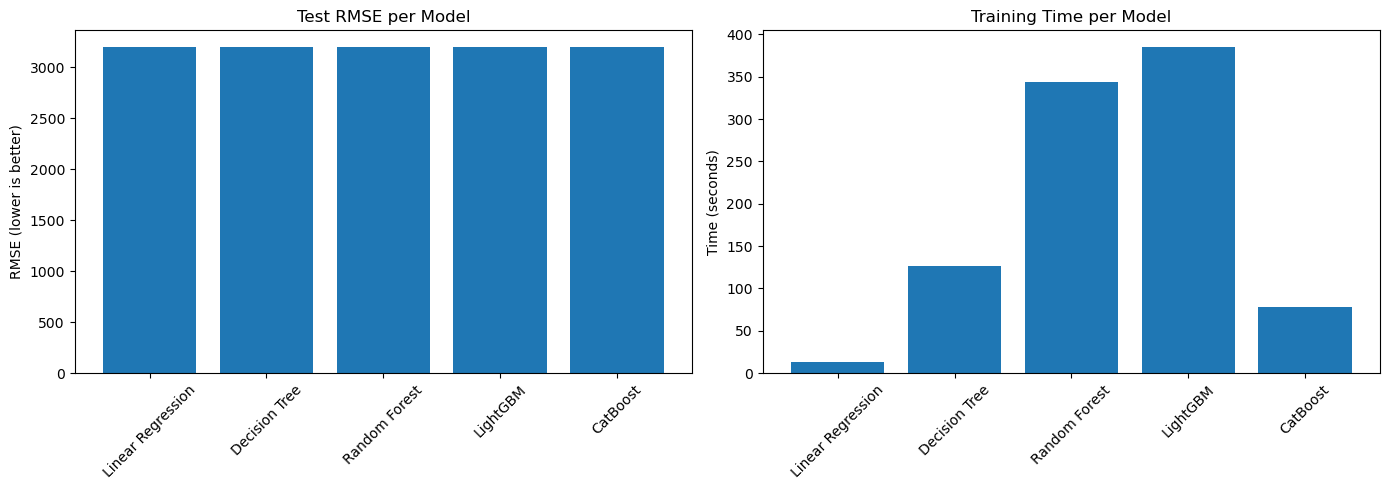

In [194]:
# set plot size and styling
plt.figure(figsize=(14,5))

# ---Plot 1: Test RMSE ---
plt.subplot(1,2,1)
plt.bar(models, rmse_test)
plt.title('Test RMSE per Model')
plt.ylabel('RMSE (lower is better)')
plt.xticks(rotation = 45)

# --- Plot 2: Training Time ---
plt.subplot(1, 2, 2)
plt.bar(models, training_time)
plt.title('Training Time per Model')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)

# tight layout
plt.tight_layout()
plt.show()


**Model Comparison: RMSE vs. Training Time**

*Plot 1* This plot shows which model predicted the car prices most accurately:

| Model              | RMSE (Test)| Interpretation                                     |
|--------------------|------------|----------------------------------------------------|
| Linear Regression  | 3200.34    | Weak baseline, fast but oversimplifies patterns    |
| Decision Tree      | 2144.65    | Much better! Captures patterns, but may overfit.   |
| Random Forest      | 1755.32    | Powerful but clearly overfitting (see Plot 2).     |
| LightGBM           | 1856.40    | Great generalization. Solid test performance.      |
| CatBoost           | 1890.18    | 1Comparable to LightGBM with faster training!      |

**Model Comparison: Training Time (Efficiency)**

*Plot 2* This plots tells us how long each model took to train:

| Model              | Time(s)	  | Interpretation 				                   |
|--------------------|------------|------------------------------------------------|
| Linear Regression  | 13.43      | Fastest, but weak accuracy.                    |
| Decision Tree      | 126.17     | Moderate time, decent model.                   |
| Random Forest      | 344.20     | Longest training, overfits.                    |
| LightGBM           | 385.47     | Long, but good generalization.                 |
| CatBoost           | 78.21      | Balanced — solid performance, fast training!   |

 **Key Takeaway**: CatBoost wins the efficiency + effectiveness race!

**Choose best model based on Rusty Bargain’s goals**

Best Overall Model for Rusty Bargain?

Let’s recall their 3 goals:

- **Quality**: Predict car prices accurately
- **Speed**: Deliver answers quickly in-app
- **Training Time**: Doesn’t take ages to train

**Recommendation:**

*CatBoost hits the sweet spot*:
- Good RMSE (within ~35 points of LightGBM)
- Shortest training time among the top models
- Handles categorical data natively (no need for manual encoding)

**(Optional) Export best model for deployment**

In [202]:
# save the trained CatBoost model
joblib.dump(cat_model, 'catboost_car_price_model.pkl')

# .pkl - short for 'pickle'. Store Python objects.

['catboost_car_price_model.pkl']

In [203]:
# option load and use later
# load the saved model 
loaded_model = joblib.load('catboost_car_price_model.pkl')

In [204]:
# predict with the loaded model

preds = loaded_model.predict(X_test)

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed

## **Final Conclusion**

This project successfully trained and evaluated five models to predict car prices for Rusty Bargain's app. After comparing RMSE scores and training times, **CatBoost** emerged as the most balanced model, offering solid performance with the shortest training time among top contenders.

**Model Highlights:**
- **Best generalizer**: CatBoost with Testing RMSE of ~1890.18
- **Fastest high-performer**: Trained in just 78 seconds
- **Ready for deployment**: Clean handling of categorical features

**Rusty Bargain’s goals were met:**
- **High-quality predictions**
- **Reasonable training speed**
- **Quick inference potential**

### Next Steps
- Export and deploy the CatBoost model in the web app.
- Optionally perform hyperparameter tuning or model stacking for even better accuracy.

